# Задание

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.

2. Подберите параметры модели SARIMAX для этого ряда.

3. Сделайте вывод о том, как изменилась модель по сравнению с недельной.

4. Возмите вариант 1 или 2 
    - Вариант 1) - Постройте ACF, PACF и модель ARIMA для BRENT (недельный ресемплинг)
    - Вариант 2) - Постройте ACF, PACF и модель ARIMA для СOVID_19  (по любой стране кроме Китая на дневных графиках )


5. Оцените результат моделирования

6. Сделайте предположение о моделях, которые лучше работают с техниками регрессии  на основе AR I MA.

# Временные ряды 3. 

# Моделируем временные ряды по ARIMA

Стационарные и нестационарные модели временных рядов требуют отдельного анализа. Отделить стационарную часть от нестационарной можно за счет правильного выбора параметров сглаживания и представления модели в виде суммы (или иногда произведения) стационарных и нестационарных частей ряда. Вопрос дня - как определить параметры сглаживания и как предсказывать стационарную часть ряда.

Пока наш алгоритм обработки ряда преодолел 2 основных этапа:
- визуализация и зачистка от проблем
- анализ характера ряда как стационарного или нестационарного

Попробуем понять, что нужно делать, что бы построить наконец модель во времени с учетом всего вместе. Будем использовать предобработанные версии этих рядов с признаками из календаря.   




## Потребление энергии

Временной ряд связан с измерением потребления энергии в отдельных регионах США в период 2002 по 2018 г. (PJM Hourly Energy Consumption Data
https://www.kaggle.com/robikscube/hourly-energy-consumption). Содержит часовые измерения и после обработки добавлены метки по времени для календаря.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os

Загрузим файл с данными и посмотрим на таблицу их организующую.

In [75]:
#Path_Energy = 'PJME_hourly.csv'
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


Описательная статистика практически не изменилась после обработки пропусков, сортировки и удаления дублей.

In [4]:
data.describe()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
count,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000
mean,32079.773047,2009.801340,6.435979,15.722681,2.481241,180.459835,26.218643,2.999168,11.501101,0.027233,0.027075,0.027240
std,6464.167501,4.791885,3.438982,8.801258,1.114448,105.138073,15.019836,1.999572,6.921927,0.162763,0.162303,0.162783
min,14544.000000,2002.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27573.000000,2006.000000,3.000000,8.000000,1.000000,90.000000,13.000000,1.000000,6.000000,0.000000,0.000000,0.000000
50%,31421.000000,2010.000000,6.000000,16.000000,2.000000,179.000000,26.000000,3.000000,12.000000,0.000000,0.000000,0.000000
75%,35648.750000,2014.000000,9.000000,23.000000,3.000000,271.000000,39.000000,5.000000,18.000000,0.000000,0.000000,0.000000
max,62009.000000,2018.000000,12.000000,31.000000,4.000000,366.000000,53.000000,6.000000,23.000000,1.000000,1.000000,1.000000


Общий вид изменения ключевого свойства ряда приведен на рис.1.

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


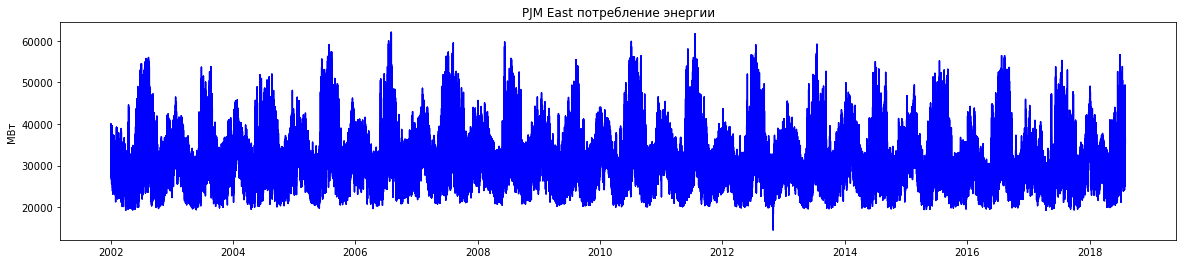

In [4]:
plt.figure(figsize =(20,4))
plt.plot( data.index, data['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

Рис.1. Потребление энергии

Характер этих рядов существенно отличается. Энергия имеет выраженный порядок смены сезонов (рис.1) и дня и ночи (рис.2). 
есть необычные артефакты: выброс 2012.10 в потреблении энергии 
Попробуем определить параметры модели для этих примеров.

In [5]:
#импорт модулей для формирования модели
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA


ARMA - Авторегрессионная модель скользящего среднего. В области анализа временных рядов модель авторегрессии (autoregressive, AR) и модель скользящего среднего (moving average, MA) является сравнительно простой и оперирует 2-мя параметрами: глубиной регрессии - р и длиной скользящего среднего - q. Чем больше q - тем больше сглаживание ряда (для нефти и Потребления энергии мы из примерно определили в процессе ресемплинга на разные интервалы).

ARIMA - Интегрированная Авторегрессионная модель скользящего среднего, построена для ряда первых разностей. Определяется на 3-х параметрах : p — порядок компоненты AR, d — порядок интегрированного ряда, q — порядок компонеты MA.


ARIMA импортируется по: 
    from statsmodels.tsa.arima_model import ARIMA

Строим ARIMA модель:
    model = ARIMA(data, order=(1, 1, 1)), где
     order - порядок модели в формате (p,d,q)
     data - собственно ряд в форме numpy массива
Построим модель по нашему объекту model через обращение к методу fit:
    model_fit = model.fit(disp=False)

Посмотрим , что построилось на старых данных:
    y_p = model_fit.predict(len(data), len(data), typ='levels')

или предскажем новые , начиная от последней точки ряда n новых точек :
    y_f =model_fit.forecast(n), где y_f - содержит 3 массива y_f[0] - основное предсказание, y_f[1] - оцекнка ошибки и y_f[2] 2-х мерный массив границ доверительного интервала


Сформированная модель устанавливает параметр p=1, d=1 и q=2. Понятно, что получение параметров модели потребовало какого-то анализа поведения ряда. И вообще говоря, модель будет работать для довольно большого диапазона параметров. Наша задача выбрать правильный тип модели сглаживания и определить какие составляющие ряда актуальны именно для нашего случая. Основные варианты описываются двумя моделями ARIMA и SARIMAX. Первый тип моделей не учитывает сезонные циклы, а второй их обработает. Дальнейший анализ позволит включить или отключить составляющие модели (р=0 - нет скользящей средней, q=0 - нет экспоненциального сглаживания, d = 0 - модель без интегральной части). 

Варианты описания задач моделирования временных рядов в statsmodels можно посмотреть в  https://www.machinelearningmastery.ru/time-series-forecasting-methods-in-python-cheat-sheet/ и докементации модуля (ссылка выше)

Итак, необходимо определить значения ARIMA (p, d, q) (текущие) и (P, D, Q) s(сезонные для SARIMAX ) параметры модели, которые оптимизируют точность соответствия модели истинной ситуации. 

Правильная параметризация моделей ARIMA вручную —  процесс довольно кропотливый, требует изучения предметной области и занимает много времени. Посмотрим на инструменты и методы подбора параметров модели ARIMA(SARIMAX). 

**Определим параметры ARIMA**. 

Для этого используем ACF (определит q) и PACF (определит p)

ACF - автокорреляционная функция, по коррелограмме которой можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA. 

PACF - автокорреляционная функция первых разностей, по коррелограмме которой можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR. 

Построим такие коррелограммы из statsmodels по функциям plot_acf() и plot_pacf(). Графики ACF и PACF, где по оси X откладываются номера лагов, а по оси Y значения соответствующих функций.

Для скорости и удобства отображения посмотрим на более простых данных - ресемплингах исходного ряда на дневные(data_d), месячные (data_m), недельные (data_w) и 3-х месячные ряды(data_Y)

In [7]:
data_d = data.copy().resample('D').mean()
data_m = data.resample('M').mean()
data_w = data.resample('W').mean()
data_Y = data.resample('3M').mean()

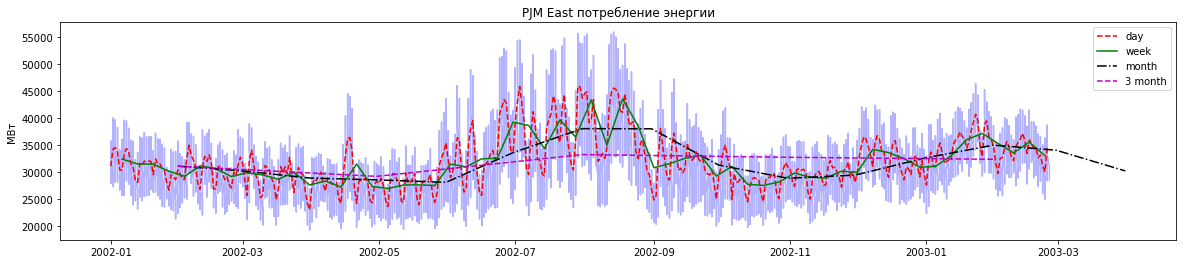

In [8]:
plt.figure(figsize =(20,4))
plt.plot( data.index[:5*24*7*4*3], data['PJME_MW'].values[:5*24*7*4*3], 'b',alpha =0.3 )
plt.plot( data_d.index[:5*7*4*3], data_d['PJME_MW'].values[:5*7*4*3], '--r',label='day' )
plt.plot( data_w.index[:5*4*3], data_w['PJME_MW'].values[:5*4*3], 'g',label='week'  )
plt.plot( data_m.index[:5*3], data_m['PJME_MW'].values[:5*3], '-.k',label='month'  )
plt.plot( data_Y.index[:5], data_Y['PJME_MW'].values[:5], '--m',label='3 month'  )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.legend()
plt.show()

Но сначала посмотрим , что можно увидеть для исходной модели (работает очень долго)

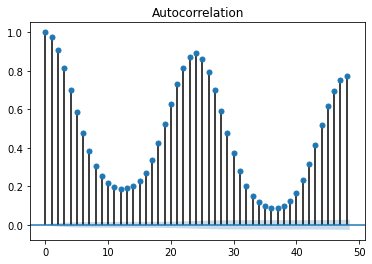

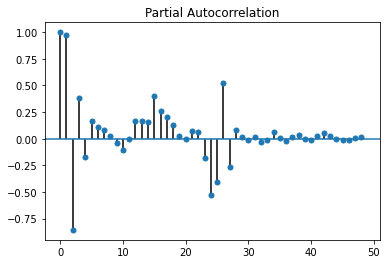

In [9]:
#plt.figure(figsize=(20,8))
#plt.subplot(2,1,1)
sm.graphics.tsa.plot_acf(data['PJME_MW'].values, lags=24*2)
plt.show()

#plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(data['PJME_MW'].values, lags=24*2)
plt.show()

Получили оценку автокорреляции часовой модели по иcходному ряду и его первым разностям. Для этой модели можно увидеть значительную автокорреляцию с лагом 24 часа(никто и не сомневался см.рис. Autocorrelation) и значительную корреляцию остатков по первым трем лагам (Partial Autocorrelation) с падением, но не нулевой корреляцией для лагов до 24 часов. Первый график говорит о параметре части MA(24) - т.е следует рассматривать ресемплинг модели (поскольку авторегрессия 24) на дневные модели. По второму графику можно сказать, что есть нестационарность и необходимо ее отделить от нашего ряда. Мы помним, что ADF нам эту нестационарность уже диагностировал (временные ряды 2). Посмотрим ресемплинг на дневные данные, т.е. сгладим наш ряд по упрощенной схеме.

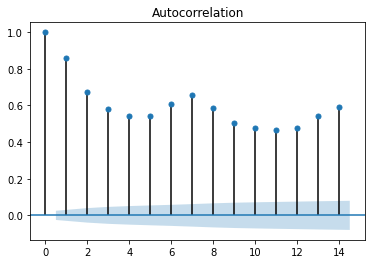

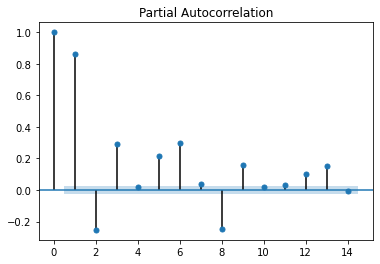

In [18]:
sm.graphics.tsa.plot_acf(data_d['PJME_MW'].values, lags=14)
plt.show()
sm.graphics.tsa.plot_pacf(data_d['PJME_MW'].values, lags=14)
plt.show()

Картина для дневных примеров имеет более общий вид, но тоже есть значительная автокорреляция по недельным лагам с медленным падением связи в течении 2-х недель(ACF). Практически аналогично выглядит картинка и для разностей(PACF) т.е. есть значительная по 1-му остатку (AR 1) и более слабые связи по неделям (до AR 8 ). Посмотрим как выглядит ряд при ресемплинге на 3-месячных данных.

На месячном графике можно увидеть, что есть ежегодный цикл (лаг 12 и 24) для ACF (МА 12) и PACF (AR 12). Это годовые сезонные изменения по всем периоду наблюдений. 

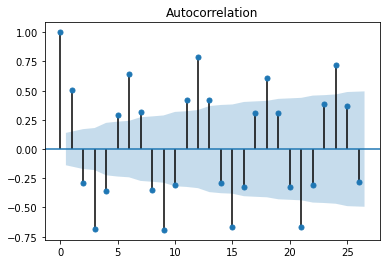

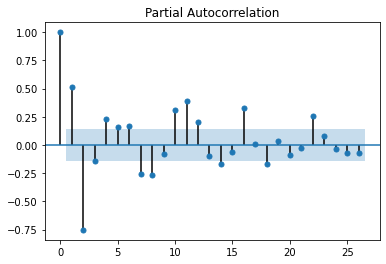

In [19]:
sm.graphics.tsa.plot_acf(data_m['PJME_MW'].values, lags=26)
plt.show()
sm.graphics.tsa.plot_pacf(data_m['PJME_MW'].values, lags=26)
plt.show()

Сохраняется корреляция для квартальных лагов (3, 6, 9 и 12 месяцы - это наши сезонные колебания - ACF) и для разностей важными являются значения внутри первых 3-х значений (PACF). Это позволит определить, что ряд сезонный и следует использовать модель сезонности с периодом 12, 6 или 3 месяца. диапазон поиска параметров модели ARIMA для лучшего описания нашего ряда в диапазоне до первых разностей и сглаживаний первого порядка. 

Рассмотрим результаты моделирования ряда с потенциально хорошими значениями порядками компонент нашего ряда с учетом сезонности в модификации SARIMAX, которая кроме всего прочего строит сезонную составляющую ряда. Фактически строим 3 модели : модель сезона и модель вокруг сезонных колебаний. А наш ряд очевидно сезонный. В качестве метрики качества используем информационный критерий Акаике (AIC) - чем меньше, тем лучше.

Обозначения для модели включают указание порядка для моделей AR (p), I (d) и MA (q) в качестве параметров функции ARIMA и AR (P), I (D), MA (Q) и m. параметры на сезонном уровне, например SARIMA (p, d, q) (P, D, Q) m, где «m» - количество временных шагов в каждом сезоне (сезонный период). Модель SARIMA может использоваться для разработки моделей AR, MA, ARMA и ARIMA. Принципиально формат обращения остается прежним (как у ARIMA), за исключением добавки сезонных параметров SARIMAX(<данные - массив ряда>,order=[p,d,q], seasonal_order=[ps,ds,qs])

In [117]:
import warnings

# Определим p, d и q 
q = 2
p = 2
d = 2
pdq = [p, d, q]
# определим комбинации сезонных параметров p, q и q, 
#будем работать с месячными данными, тогда сезонность это 12 месяцев
qs = 1
ps = 0
ds = 0
seasonal_pdq = [ps, ds, qs ,12] 


In [118]:
print('SARIMAX: p,d,q=',pdq,'   : ps,ds,qs, S=', seasonal_pdq)

SARIMAX: p,d,q= [2, 2, 2]    : ps,ds,qs, S= [0, 0, 1, 12]


In [119]:
#для построения модели используем все данные, кроме 6ти последних месяцев (это будет тестовый набор)
warnings.filterwarnings("ignore") # отключает предупреждения

mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-12],order=pdq,
                                seasonal_order=seasonal_pdq ,
                                enforce_stationarity= False ,
                                enforce_invertibility=False)
results = mod.fit()
print('SARIMAX{}x{} - AIC:{}'.format(pdq, seasonal_pdq, results.aic))


SARIMAX[2, 2, 2]x[0, 0, 1, 12] - AIC:3115.9610161032815


In [86]:
print(result_first.summary().tables[0],result_first.summary().tables[1])

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  188
Model:             SARIMAX(2, 2, 2)x(0, 0, [1], 12)   Log Likelihood               -1551.981
Date:                              Sat, 18 Apr 2020   AIC                           3115.961
Time:                                      18:33:01   BIC                           3134.811
Sample:                                           0   HQIC                          3123.610
                                              - 188                                         
Covariance Type:                                opg                                         
============================================================================================ ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----

Анализ результатов по results:
- коэффициенты при элементах модели имеют большие значения (особенно важны составляющие сглаживания coef:  ma.L1, ma.L2 , ma.S.L26 и коэффициенты регрессии ar.L2 и ar.L1)
- можно посмотреть на остатки ряда (results.resid) с точки зрения автокорреляции и убедиться, что они не имеют значительной корреляции (это хорошо, т.к. остатки имеют характер белого шума)

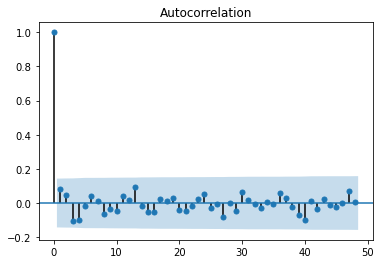

In [87]:
sm.graphics.tsa.plot_acf(results.resid, lags=48)
plt.show()

Оценим близости распределений остатков модели к нормальному закону используя визуализацию plot_diagnostics: 
- левый верхний график - остатки ряда 
- правый верхний - гистограмма для остатков ряда
- левый нижний - упорядоченное распределение остатков (квантильное)
- правый нижний - коррелограмма остатков

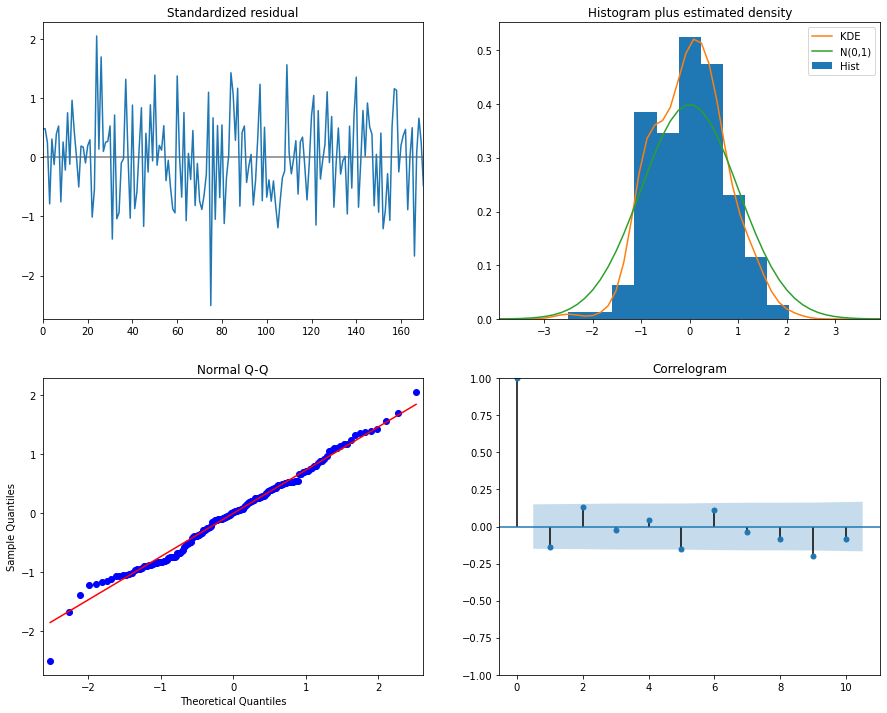

In [88]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()


В этом случае диагностика показала, что остатки модели правильно распределяются:
- estimated density на верхнем-правом графике красная линия KDE находится близко к линии N (0,1) (где N (0,1) является стандартным обозначением нормального распределения со средним 0 и стандартным отклонением 1) . Очевидно, что остатки нормально распределены.
- График q-q в левом нижнем углу показывает, что упорядоченное распределение остатков (синие точки) следует линейному тренду выборок, взятых из стандартного распределения N (0, 1). Опять же, это признак того, что остатки нормально распределены.
- Остатки с течением времени (верхний левый график) не показывают явной сезонности и кажутся белыми шумами. Это подтверждается графиком автокорреляции (внизу справа), который показывает, что остатки временных рядов имеют низкую корреляцию с запаздывающими данными.

Эти графики позволяют сделать вывод о том, что выбранная модель (удовлетворительно) подходит для анализа и прогнозирования данных временных рядов.

## Подобрать параметры модели можно используя сеточный выбор как это сделано для ряда "Потребление энергии" ниже (работает долго!):

- На основании анализа выбираем диапазон изменения параметров сезонности и остатка ряда (для этой модели берем [0,3]).
    
- задаем длину сезона (здесь 52 недели, 12 месяцев)
    
- Запускаем генерацию сетки с использованием модуля itertools (itertools.product(p, d, q) - сгенерит декартово множество по p,d,q диапазонам) и задаем полный список вариантов.
    
- Запускаем генерацию SARIMAX - с параметрами и возвращаем AIC.
    
- Лучшее значение параметров (при минимальной оценке AIC) используем для настройки финальной модели.

In [111]:
import itertools

# Определим p, d и q в диапазоне 0-3
p = d = q = range(0, 3)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))
# зададим сезонность p, q и q

p = [0,2] 
d = [0,1]
q = range(0, 3)

seasonal_pdqw = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


In [112]:
data_m['PJME_MW'].values.shape

(200,)

In [113]:
warnings.filterwarnings("ignore") # отключает предупреждения
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-24],order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results = mod.fit()
            print('ARIMA{}x{}3 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)3 - AIC:4134.131475716988
ARIMA(0, 0, 0)x(0, 0, 1, 12)3 - AIC:3741.798369699642
ARIMA(0, 0, 0)x(0, 0, 2, 12)3 - AIC:3443.5660918410886
ARIMA(0, 0, 0)x(0, 1, 0, 12)3 - AIC:2934.763927613225
ARIMA(0, 0, 0)x(0, 1, 1, 12)3 - AIC:2711.2198161762562
ARIMA(0, 0, 0)x(0, 1, 2, 12)3 - AIC:2480.669916805543
ARIMA(0, 0, 0)x(2, 0, 0, 12)3 - AIC:2722.181117231807
ARIMA(0, 0, 0)x(2, 0, 1, 12)3 - AIC:2724.2483839437164
ARIMA(0, 0, 0)x(2, 0, 2, 12)3 - AIC:2686.6849532555216
ARIMA(0, 0, 0)x(2, 1, 0, 12)3 - AIC:2493.7894042526596
ARIMA(0, 0, 0)x(2, 1, 1, 12)3 - AIC:2489.783550508402
ARIMA(0, 0, 0)x(2, 1, 2, 12)3 - AIC:2475.4893819743884
ARIMA(0, 0, 1)x(0, 0, 0, 12)3 - AIC:3986.567470965028
ARIMA(0, 0, 1)x(0, 0, 1, 12)3 - AIC:3682.2693991263204
ARIMA(0, 0, 1)x(0, 0, 2, 12)3 - AIC:3405.2472559784765
ARIMA(0, 0, 1)x(0, 1, 0, 12)3 - AIC:2894.3605697213434
ARIMA(0, 0, 1)x(0, 1, 1, 12)3 - AIC:2673.946923006518
ARIMA(0, 0, 1)x(0, 1, 2, 12)3 - AIC:2444.2698943716973
ARIMA(0, 0, 1)x(2,

ARIMA(1, 1, 0)x(2, 0, 1, 12)3 - AIC:2678.785218995805
ARIMA(1, 1, 0)x(2, 0, 2, 12)3 - AIC:2675.865779449603
ARIMA(1, 1, 0)x(2, 1, 0, 12)3 - AIC:2464.383874929068
ARIMA(1, 1, 0)x(2, 1, 1, 12)3 - AIC:2465.450703987795
ARIMA(1, 1, 0)x(2, 1, 2, 12)3 - AIC:2465.4421707752017
ARIMA(1, 1, 1)x(0, 0, 0, 12)3 - AIC:3282.2684957739975
ARIMA(1, 1, 1)x(0, 0, 1, 12)3 - AIC:2991.616981083962
ARIMA(1, 1, 1)x(0, 0, 2, 12)3 - AIC:2725.574007161551
ARIMA(1, 1, 1)x(0, 1, 0, 12)3 - AIC:2911.2430243105887
ARIMA(1, 1, 1)x(0, 1, 1, 12)3 - AIC:2633.9442451453247
ARIMA(1, 1, 1)x(0, 1, 2, 12)3 - AIC:2421.4000340839193
ARIMA(1, 1, 1)x(2, 0, 0, 12)3 - AIC:2664.8011475154103
ARIMA(1, 1, 1)x(2, 0, 1, 12)3 - AIC:2649.4394245051863
ARIMA(1, 1, 1)x(2, 0, 2, 12)3 - AIC:2639.399000288564
ARIMA(1, 1, 1)x(2, 1, 0, 12)3 - AIC:2458.3714453632438
ARIMA(1, 1, 1)x(2, 1, 1, 12)3 - AIC:2441.9144319069455
ARIMA(1, 1, 1)x(2, 1, 2, 12)3 - AIC:2418.008582979121
ARIMA(1, 1, 2)x(0, 0, 0, 12)3 - AIC:3204.4496338844774
ARIMA(1, 1, 2)x(0,

ARIMA(2, 2, 1)x(0, 0, 2, 12)3 - AIC:2758.3820659855946
ARIMA(2, 2, 1)x(0, 1, 0, 12)3 - AIC:2935.144818803672
ARIMA(2, 2, 1)x(0, 1, 1, 12)3 - AIC:2663.478917068104
ARIMA(2, 2, 1)x(0, 1, 2, 12)3 - AIC:2424.4910192414864
ARIMA(2, 2, 1)x(2, 0, 0, 12)3 - AIC:2659.6259599904943
ARIMA(2, 2, 1)x(2, 0, 1, 12)3 - AIC:2640.0986475526406
ARIMA(2, 2, 1)x(2, 0, 2, 12)3 - AIC:2708.6615260776407
ARIMA(2, 2, 1)x(2, 1, 0, 12)3 - AIC:2441.649291923004
ARIMA(2, 2, 1)x(2, 1, 1, 12)3 - AIC:2426.6616421924045
ARIMA(2, 2, 1)x(2, 1, 2, 12)3 - AIC:2427.701511199516
ARIMA(2, 2, 2)x(0, 0, 0, 12)3 - AIC:3126.6754328571856
ARIMA(2, 2, 2)x(0, 0, 1, 12)3 - AIC:2903.095430275216
ARIMA(2, 2, 2)x(0, 0, 2, 12)3 - AIC:2689.2519317264077
ARIMA(2, 2, 2)x(0, 1, 0, 12)3 - AIC:2914.146089670012
ARIMA(2, 2, 2)x(0, 1, 1, 12)3 - AIC:2633.132276049282
ARIMA(2, 2, 2)x(0, 1, 2, 12)3 - AIC:2421.7992745159713
ARIMA(2, 2, 2)x(2, 0, 0, 12)3 - AIC:2689.4611703113173
ARIMA(2, 2, 2)x(2, 0, 1, 12)3 - AIC:2685.821453731564
ARIMA(2, 2, 2)x(2,

Лучшие результаты на недельных данных параметры модели SARIMA(0,0, 1)x(1, 1, 2, 52) - AIC:14254.93 (для p,q,d,ps,ds,qs из диапазона [0,1,2]).

Лучшие результаты на месячных данных параметры модели SARIMA(0,1, 2)x(0, 1, 2, 12) - AIC:2405 (для p,q,d,ps,ds,qs из диапазона [2,2,2]). Вот только не понял, почему возникает nan при некоторых параметрах, значение в логарфме случайно запрещенное попалось (Это было, когда выбока была не по всем месяцам)?

In [115]:
#для построения модели используем все данные, кроме 12-ти последних месяцев (это будет тестовый набор)
warnings.filterwarnings("ignore") # отключает предупреждения

mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-36],order=[0,1,2],
                                seasonal_order=[0,1,2,12] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print('AIC:{}',results_opt.aic)


AIC:{} 2188.839534397864


Проведем моделирование прогноза на основе найденой SARIMAX[0, 2, 2]x[0, 0, 1, 52] - AIC:14705.36 и модели  SARIMA(1, 2, 2)x(0, 0, 1, 52) для последних 12 дней(и предсказание следующих 30 )  и сравним их с фактом.

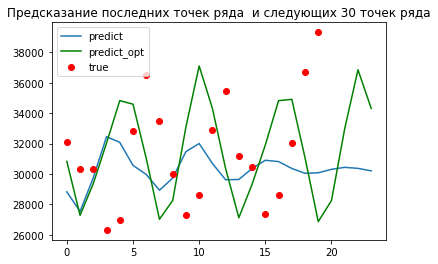

In [120]:
pred_dynamic = results.forecast(24)    #делаем предсказание на 3 точки от текущего конца ряда
pred_dynamic_opt = results_opt.forecast(24)

plt.plot(pred_dynamic, label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(data_m['PJME_MW'].values[-20:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 30 точек ряда')
plt.legend()

plt.show()

Видно, что предсказание новых точек тем слабее, чем дальше от последней известной точки ряда. Это можно объяснить тем, что накапливается ошибка предсказания или изменились условия развития ряда (наш котенок перестанет когда-нибудь расти и следовательно его скорость и маневренность долгое время не будут изменяться). Кроме того, модель, которую выбрали по сетке, немного лучше обходит точки известные нам заранее и имеет более сложный характер. Таким образом, подбор позволил улучшить исходный результат для ряда с сезонами и циклами. 

По сравнению с недельной моделью, AIC оказался меньше, что не удивительно, более плавную кривую легче предсказать.


- Вариант 1) - Постройте ACF, PACF и модель ARIMA для BRENT (недельный ресемплинг)
 

5. Оцените результат моделирования

6. Сделайте предположение о моделях, которые лучше работают с техниками регрессии  на основе AR I MA.

In [124]:
path_brent = 'my_BRENT2019.csv'
brent_data = pd.read_csv(path_brent,sep = ',', index_col=[0], parse_dates=[0])
brent_data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


In [138]:
brent_data_w = brent_data.resample('W').mean()
brent_data_w.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-05,76.616000,2010.0,9.000000,3.000000,3.000000,246.000000,35.0,4.000000,0.000000,0.2,0.000000
2010-09-12,77.673333,2010.0,9.000000,8.500000,3.000000,251.500000,36.0,2.500000,0.166667,0.0,0.166667
2010-09-19,78.693333,2010.0,9.000000,15.666667,3.000000,258.666667,37.0,2.666667,0.000000,0.0,0.000000
2010-09-26,78.518333,2010.0,9.000000,22.666667,3.000000,265.666667,38.0,2.666667,0.000000,0.0,0.000000
2010-10-03,81.211667,2010.0,9.333333,19.666667,3.333333,272.666667,39.0,2.666667,0.000000,0.0,0.000000


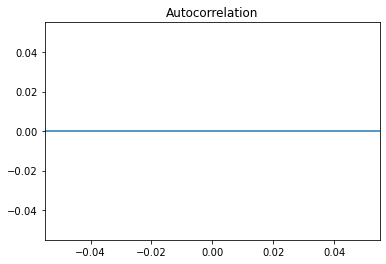

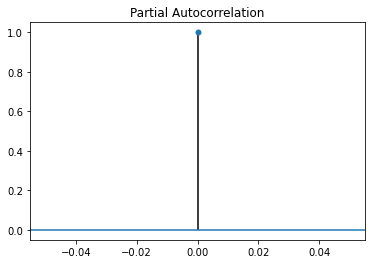

In [173]:
#plt.figure(figsize=(20,8))
#plt.subplot(2,1,1)
sm.graphics.tsa.plot_acf(brent_data_w['Значение'].values, lags=30)
plt.show()
#plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(brent_data_w['Значение'].values, lags=30)
plt.show()

 Вывод такой, что не интересно это дальше исследовать, займусь COVID. Или такой график из-за ошибки?

Вариант 2) - Постройте ACF, PACF и модель ARIMA для СOVID_19 (по любой стране кроме Китая на дневных графиках ) Оцените результат моделирования
Сделайте предположение о моделях, которые лучше работают с техниками регрессии  на основе AR I MA.

In [140]:
COVID = pd.read_csv('covid_19_data.csv')
COVID.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [141]:
COVID['Data']= pd.to_datetime(COVID['ObservationDate']).dt.date

In [144]:
COVID = COVID.groupby(['Data','Country/Region'])['Confirmed','Deaths','Recovered'].sum()

In [145]:
COVID.head(30)

Confirmed  Deaths  Recovered
Data       Country/Region                              
2020-01-22 Hong Kong             0.0     0.0        0.0
           Japan                 2.0     0.0        0.0
           Macau                 1.0     0.0        0.0
           Mainland China      547.0    17.0       28.0
           South Korea           1.0     0.0        0.0
           Taiwan                1.0     0.0        0.0
           Thailand              2.0     0.0        0.0
           US                    1.0     0.0        0.0
2020-01-23 Australia             0.0     0.0        0.0
           Brazil                0.0     0.0        0.0
           Colombia              0.0     0.0        0.0
           Hong Kong             2.0     0.0        0.0
           Japan                 1.0     0.0        0.0
           Macau                 2.0     0.0        0.0
           Mainland China      639.0    18.0       30.0
           Malaysia              0.0     0.0        0.0
           Mexico                0.0     0.0        0.0
           Philippines           0.0     0.0        0.0
           Singapore             1.0     0.0        0.0
           South Korea           1.0     0.0        0.0
           Taiwan                1.0     0.0        0.0
           Thailand              3.0     0.0        0.0
           US                    1.0     0.0        0.0
           Vietnam               2.0     0.0        0.0
2020-01-24 France                2.0     0.0        0.0
           Hong Kong             2.0     0.0        0.0
           Japan                 2.0     0.0        0.0
           Macau                 2.0     0.0        0.0
           Mainland China      916.0    26.0       36.0
           Singapore             3.0     0.0        0.0

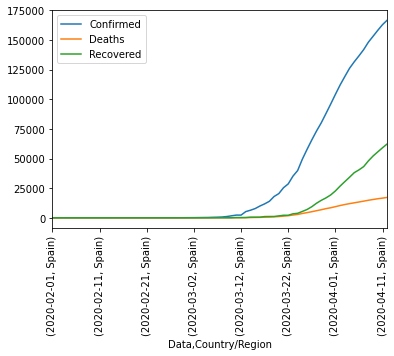

In [151]:
COVID.loc[COVID.index.get_level_values( 'Country/Region')=='Spain', ['Confirmed','Deaths','Recovered']].plot()
plt.xticks(label = COVID.index.get_level_values('Data'), rotation=90)

plt.show()

In [187]:
COV_S = COVID.loc[COVID.index.get_level_values( 'Country/Region')=='Spain', ['Confirmed','Deaths','Recovered']]
COV_S = COV_S[-72:]  #Обрежу начало
COV_S.head(20)

,,Confirmed,Deaths,Recovered
Data,Country/Region,,,
2020-02-01,Spain,1.0,0.0,0.0
2020-02-02,Spain,1.0,0.0,0.0
2020-02-03,Spain,1.0,0.0,0.0
2020-02-04,Spain,1.0,0.0,0.0
2020-02-05,Spain,1.0,0.0,0.0
2020-02-06,Spain,1.0,0.0,0.0
2020-02-07,Spain,1.0,0.0,0.0
2020-02-08,Spain,1.0,0.0,0.0
2020-02-09,Spain,2.0,0.0,0.0


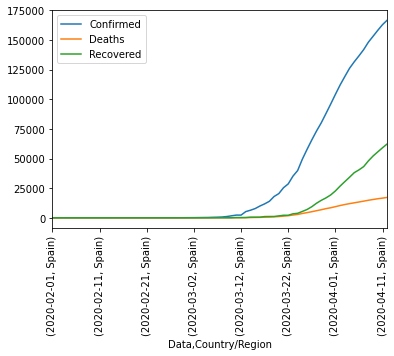

In [188]:
COV_S.plot()
plt.xticks(label = COV_S.index.get_level_values('Data'), rotation=90)
plt.show()



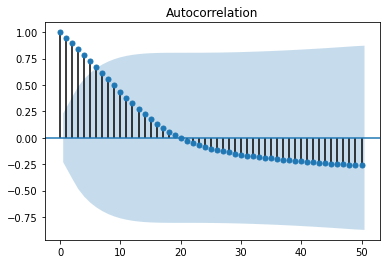

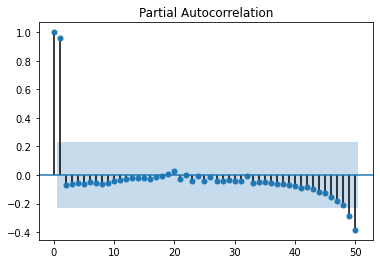

In [189]:
sm.graphics.tsa.plot_acf(COV_S['Confirmed'].values, lags=50)
plt.show()
sm.graphics.tsa.plot_pacf(COV_S['Confirmed'].values, lags=50)
plt.show()


In [190]:
# Сезонности не обнаружено, по всплеску на 2 графике нужно обладать информацией, тесты на вирус например завезли

In [191]:
# Определим p, d и q 
q = 1
p = 1
d = 1
pdq = [p, d, q]


warnings.filterwarnings("ignore") # отключает предупреждения

modb = sm.tsa.statespace.SARIMAX(COV_S['Confirmed'].values[:-10],
                               order=pdq,seasonal_order=[0,0,0,0], trend='ct',
                               enforce_stationarity=False,
                               enforce_invertibility=False)
resultsb = modb.fit()
print('ARIMA{} - AIC:{}'.format(pdq, resultsb.aic))

print(resultsb.summary().tables[0],resultsb.summary().tables[1])

ARIMA[1, 1, 1] - AIC:977.2524349628155
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   62
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -483.626
Date:                Sat, 18 Apr 2020   AIC                            977.252
Time:                        22:25:06   BIC                            987.640
Sample:                             0   HQIC                           981.307
                                 - 62                                         
Covariance Type:                  opg                                         
============================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -

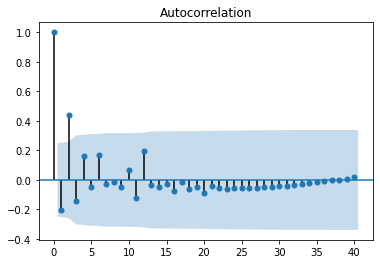

In [192]:
sm.graphics.tsa.plot_acf(resultsb.resid, lags=40)
plt.show()

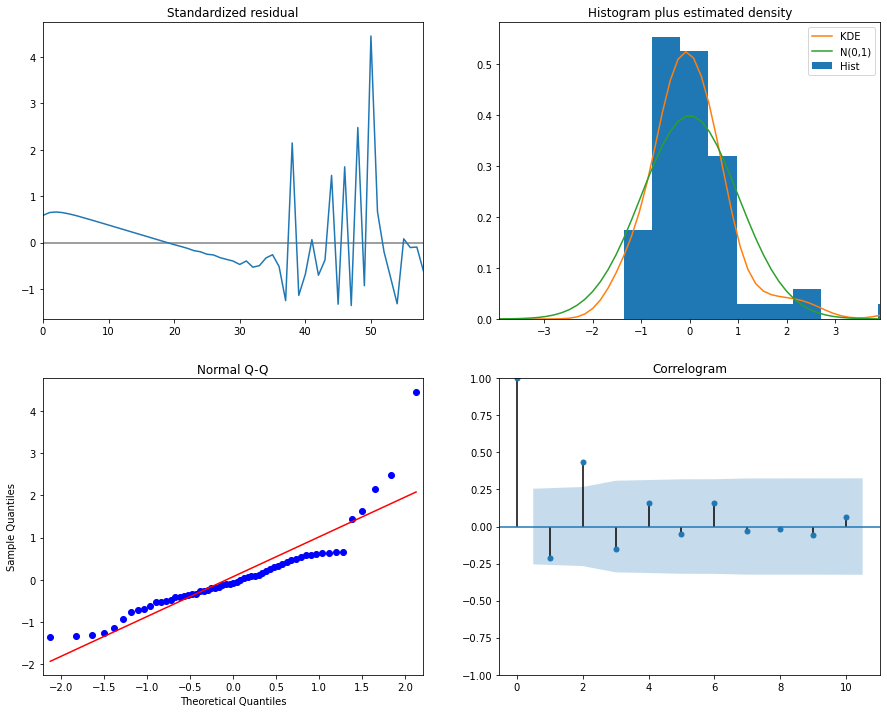

In [194]:
resultsb.plot_diagnostics(figsize=(15, 12))
plt.show()

В этом случае диагностика показала, что остатки модели  распределяются неправильно:
  Остатки с течением времени не похожи на белый шум
  estimated density на верхнем-правом графике красная линия KDE находится близко к линии N (0,1) (где N (0,1) является стандартным обозначением нормального распределения со средним 0 и стандартным отклонением 1). Гистограмма показывает нам, что остатки не совсем нормально распределены, основная схожесть в центре.
  График q-q в левом нижнем углу показывает, что упорядоченное распределение остатков (синие точки) следует линейному тренду выборок лишь в середине выборки.    
  График автокорреляции (внизу справа), который показывает, что остатки временных рядов почти не имеют корреляцию с запаздывающими данными

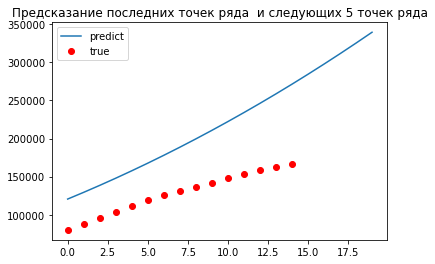

In [195]:
pred_dynamic = resultsb.forecast(20)

plt.plot(pred_dynamic, label='predict' )
#Отобразим истинный значения 
plt.plot(COV_S['Confirmed'].values[-15:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 5 точек ряда')
plt.legend()
plt.plot()
plt.show()

In [196]:
d = range(0, 4)
p = range(0, 4)
q = range(0, 8)

pdq = list(itertools.product(p, d, q))

seasonal_pdq = [0,0,0,0] # нет сезона

warnings.filterwarnings("ignore") # отключает предупреждения

for param in pdq:
    param_seasonal = seasonal_pdq
    try:
        mod_b = sm.tsa.statespace.SARIMAX(COV_S['Confirmed'].values[:-12],
                                          order=param,seasonal_order=[0,0,0,0],trend='ct',
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)

        results_ = mod_b.fit()
        print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results_.aic))
    except:
        continue

ARIMA(0, 0, 0)x[0, 0, 0, 0] - AIC:1322.1319386574246
ARIMA(0, 0, 1)x[0, 0, 0, 0] - AIC:1260.658528803754
ARIMA(0, 0, 2)x[0, 0, 0, 0] - AIC:1255.604684072693
ARIMA(0, 0, 3)x[0, 0, 0, 0] - AIC:1284.0010722785858
ARIMA(0, 0, 4)x[0, 0, 0, 0] - AIC:1182.8764348975617
ARIMA(0, 0, 5)x[0, 0, 0, 0] - AIC:1153.473475695167
ARIMA(0, 0, 6)x[0, 0, 0, 0] - AIC:1359.2130790211404
ARIMA(0, 0, 7)x[0, 0, 0, 0] - AIC:1200.1548443666682
ARIMA(0, 1, 0)x[0, 0, 0, 0] - AIC:1035.7752432333605
ARIMA(0, 1, 1)x[0, 0, 0, 0] - AIC:997.749257735511
ARIMA(0, 1, 2)x[0, 0, 0, 0] - AIC:950.491973998676
ARIMA(0, 1, 3)x[0, 0, 0, 0] - AIC:932.404133534645
ARIMA(0, 1, 4)x[0, 0, 0, 0] - AIC:901.6138370904877
ARIMA(0, 1, 5)x[0, 0, 0, 0] - AIC:892.2906349330589
ARIMA(0, 1, 6)x[0, 0, 0, 0] - AIC:868.2488835114358
ARIMA(0, 1, 7)x[0, 0, 0, 0] - AIC:871.3952831860499
ARIMA(0, 2, 0)x[0, 0, 0, 0] - AIC:965.2141203351878
ARIMA(0, 2, 1)x[0, 0, 0, 0] - AIC:924.8056415428184
ARIMA(0, 2, 2)x[0, 0, 0, 0] - AIC:907.1741156026332
ARIMA(0, 

Наилучший результат у  модели ARIMA(0, 3, 7)- AIC:838

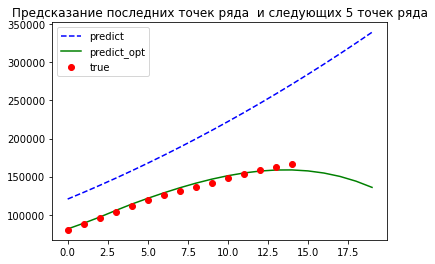

In [201]:
modb_opt = sm.tsa.statespace.SARIMAX(COV_S['Confirmed'].values[:-15],
                               order=[0,3,7],seasonal_order=[0,0,0,0],trend='ct',
                               enforce_stationarity=False,
                               enforce_invertibility=False)
resultsb_opt = modb_opt.fit()
pred_dynamic = resultsb.forecast(20)    #делаем предсказание на 3 точки от текущего конца ряда
pred_dynamic_opt = resultsb_opt.forecast(20) 

plt.plot(pred_dynamic,'--b', label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(COV_S['Confirmed'].values[-15:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 5 точек ряда')
plt.legend()
plt.plot()
plt.show()

Оптимизированная модель гораздо лучше предсказала будущий рост, но для этого пришлось поиграть с числами. Реальная модель распространение вируса очень сложна и помимо времени там множество других факторов, которые люди смогут большей частью найти наверное через год, после оценки множества в т.ч. неожиданных факторов. 
Для предсказаний с  на основе ARIMA  лучше подходят данные, которые ожидаемо связаны со временем, где меньше доля человеческого и случайных факторов.